## 📱 Project Introduction: Smart Plan Selector for Megaline

Megaline, a mobile carrier, seeks to modernize its customer base by transitioning subscribers from outdated plans to newer, more efficient offerings — **Smart** or **Ultra**. To support this initiative, we aim to develop a **classification model** that analyzes user behavior and recommends the most suitable plan.

Leveraging preprocessed usage data from users who have already made the switch, the model will learn patterns across:

- 📞 Number of calls  
- ⏱️ Total call duration (minutes)  
- 💬 Number of text messages  
- 🌐 Internet usage (MB)

The objective is to **accurately classify** users into the correct plan, with a target accuracy of **at least 0.75** on the test set.

This project involves:
- Splitting the dataset into training, validation, and test sets  
- Training and tuning various classification models  
- Evaluating model performance on the test set  
- Performing sanity checks on results to ensure reliability  

Through thoughtful modeling and evaluation, this solution enables data-driven recommendations that support Megaline’s customer migration strategy.


## Environment Setup and Required Libraries

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

## Step 1: Loading and Initial Data Exploration

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv') 
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


### 🔍 Step 1 Summary: Loading and Initial Data Exploration

The dataset was successfully loaded with **3,214 observations** across five features: `calls`, `minutes`, `messages`, `mb_used`, and `is_ultra`. All columns have appropriate data types and contain **no missing values**.

Initial statistical analysis reveals:

- User behavior varies widely, especially in data usage (`mb_used`) and call minutes.
- The `is_ultra` column — our target variable — has a **mean of ~0.31**, indicating that the majority of users are currently on the **Smart plan (0)** rather than **Ultra (1)**.
- No major anomalies are present; distributions appear consistent with realistic mobile usage patterns.

This step confirms the dataset is **clean and ready for modeling**, with a slight class imbalance favoring the Smart plan.


## Step 2: Smart and Ultra Plan Discovery

In [5]:
# Discovery of Smart plan
smart_df = df[df['is_ultra']==0]
smart_df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


In [6]:
# Discovery of Ultra Plan
ultra_df = df[df['is_ultra']==1]
ultra_df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


### 📊 Smart vs. Ultra Plan Summary

A comparison of Smart and Ultra plan users highlights distinct differences in usage behavior:

| Feature      | **Smart Plan** (mean / median / max)      | **Ultra Plan** (mean / median / max)      | **Insight**                                      |
|--------------|--------------------------------------------|--------------------------------------------|--------------------------------------------------|
| **Calls**     | 58.5 / 60 / 198                            | 73.4 / 74 / 244                            | Ultra users make more calls overall              |
| **Minutes**   | 406 / 411 / 1390                           | 511 / 503 / 1632                           | Ultra users spend more time on calls             |
| **Messages**  | 33.4 / 28 / 143                            | 49.4 / 38 / 224                            | Ultra users send more messages                   |
| **MB Used**   | 16,208 / 16,507 / 38,553                   | 19,469 / 19,308 / 49,746                   | Ultra users consume more internet data           |

**Key Takeaway:**  
Users on the **Ultra plan consistently exhibit higher usage** across all features—calls, minutes, messages, and data. This suggests that higher-usage customers are more likely to benefit from and be placed on the Ultra plan.


## Step 3: Split the source data

In [7]:
# First split: Train (60%) and Temp (40%)
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['is_ultra'])

# Second split: Validation (20%) and Test (20%) from Temp
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=12345, stratify=df_temp['is_ultra'])

train_features = df_train.drop(['is_ultra'], axis=1)
train_target = df_train['is_ultra']

valid_features = df_valid.drop(['is_ultra'], axis=1)
valid_target = df_valid['is_ultra']

test_features = df_test.drop(['is_ultra'], axis=1)
test_target = df_test['is_ultra']


## Step 4: Investigate the quality of different models
Testing the three common Classification models seems appropriate for this task

### DecisionTree

In [8]:
# Start with DecisionTree
model = DecisionTreeClassifier(random_state=12345)
model.fit(train_features, train_target)
predictions = model.predict(valid_features)
result = accuracy_score(valid_target, predictions)
result

0.7013996889580093

With no hyperparameters, the accurancy was not our target goal. Let's improve the model.

In [9]:
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=12345))
])

param_grid_dt = {
    'clf__max_depth': list(range(1, 11))
}

grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5)
grid_dt.fit(train_features, train_target)

y_pred_dt = grid_dt.best_estimator_.predict(valid_features)
y_proba_dt = grid_dt.best_estimator_.predict_proba(valid_features)[:, 1]
results_dt = {
    'accuracy': grid_dt.best_estimator_.score(valid_features, valid_target),
    'roc_auc': roc_auc_score(valid_target, y_proba_dt),
    'report': classification_report(valid_target, y_pred_dt, output_dict=True)
}
results_dt['accuracy'], grid_dt.best_params_

(0.7744945567651633, {'clf__max_depth': 6})

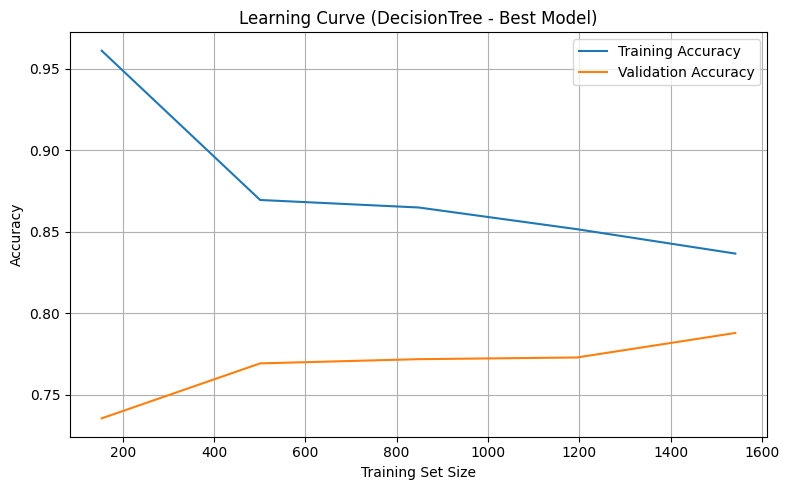

In [10]:
# Extract the best pipeline (from GridSearchCV)
dt_model = grid_dt.best_estimator_

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    dt_model,                      # use best estimator
    train_features,
    train_target,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1                            # optional: parallel processing
)

# Calculate mean scores
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.title('Learning Curve (DecisionTree - Best Model)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### RandomForest
we're going to skip a normal model and aim for improvement immediately 

In [11]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=12345))
])

param_grid_rf = {
    'clf__n_estimators': list(range(1, 45)),
    'clf__max_depth': [3, 5, 7]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5)
grid_rf.fit(train_features, train_target)

y_pred_rf = grid_rf.best_estimator_.predict(valid_features)
y_proba_rf = grid_rf.best_estimator_.predict_proba(valid_features)[:, 1]
results_rf = {
    'accuracy': grid_rf.best_estimator_.score(valid_features, valid_target),
    'roc_auc': roc_auc_score(valid_target, y_proba_rf),
    'report': classification_report(valid_target, y_pred_rf, output_dict=True)
}
results_rf, grid_rf.best_params_

({'accuracy': 0.7884914463452566,
  'roc_auc': 0.7655015820263595,
  'report': {'0': {'precision': 0.789179104477612,
    'recall': 0.9484304932735426,
    'f1-score': 0.8615071283095723,
    'support': 446},
   '1': {'precision': 0.7850467289719626,
    'recall': 0.4263959390862944,
    'f1-score': 0.5526315789473684,
    'support': 197},
   'accuracy': 0.7884914463452566,
   'macro avg': {'precision': 0.7871129167247872,
    'recall': 0.6874132161799185,
    'f1-score': 0.7070693536284703,
    'support': 643},
   'weighted avg': {'precision': 0.7879130423086961,
    'recall': 0.7884914463452566,
    'f1-score': 0.7668749615531895,
    'support': 643}}},
 {'clf__max_depth': 5, 'clf__n_estimators': 9})

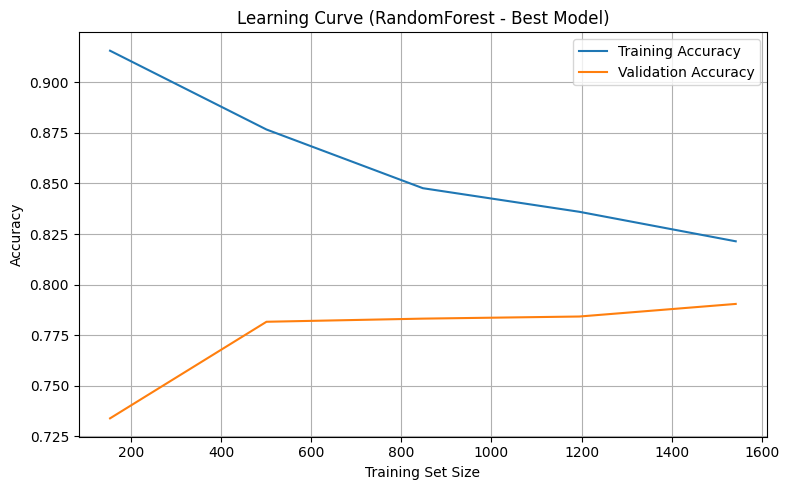

In [12]:
# Extract the best pipeline (from GridSearchCV)
rf_model = grid_rf.best_estimator_

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    rf_model,                      # use best estimator
    train_features,
    train_target,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1                            # optional: parallel processing
)

# Calculate mean scores
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.title('Learning Curve (RandomForest - Best Model)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Logistic Regression

In [13]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5)
grid_lr.fit(train_features, train_target)

y_pred_lr = grid_lr.best_estimator_.predict(valid_features)
y_proba_lr = grid_lr.best_estimator_.predict_proba(valid_features)[:, 1]
results_lr = {
    'accuracy': grid_lr.best_estimator_.score(valid_features, valid_target),
    'roc_auc': roc_auc_score(valid_target, y_proba_lr),
    'report': classification_report(valid_target, y_pred_lr, output_dict=True)
}

results_lr['accuracy']

0.7433903576982893

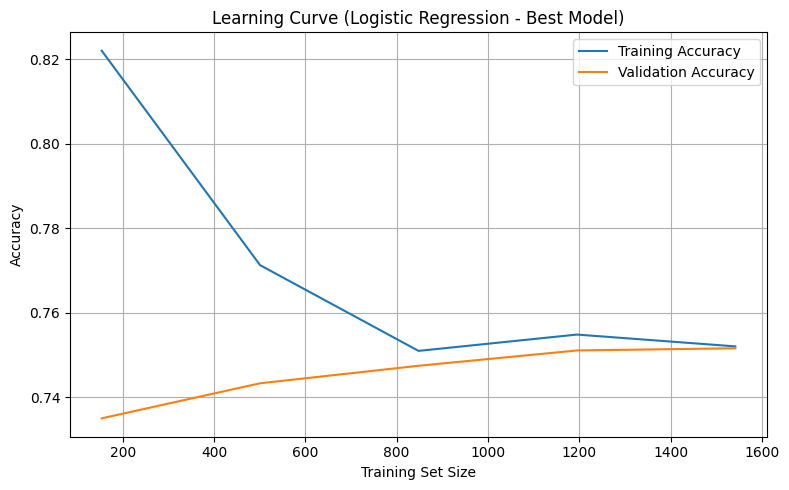

In [14]:
# Extract the best pipeline (from GridSearchCV)
lr_model = grid_lr.best_estimator_

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lr_model,                      # use best estimator
    train_features,
    train_target,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1                            # optional: parallel processing
)

# Calculate mean scores
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.title('Learning Curve (Logistic Regression - Best Model)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Gradient Boosting

In [15]:
pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=42))
])

param_grid_gb = {
    'clf__n_estimators': list(range(1, 20)),
    'clf__learning_rate': [round(x * 0.05, 2) for x in range(1, 11)],
    'clf__max_depth': [3, 4, 5, 7]
}

grid_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=3)
grid_gb.fit(train_features, train_target)

y_pred_gb = grid_gb.best_estimator_.predict(valid_features)
y_proba_gb = grid_gb.best_estimator_.predict_proba(valid_features)[:, 1]
results_gb = {
    'accuracy': grid_gb.best_estimator_.score(valid_features, valid_target),
    'roc_auc': roc_auc_score(valid_target, y_proba_gb),
    'report': classification_report(valid_target, y_pred_gb, output_dict=True)
}

results_gb, grid_gb.best_params_

({'accuracy': 0.8055987558320373,
  'roc_auc': 0.7852313855819354,
  'report': {'0': {'precision': 0.8104448742746615,
    'recall': 0.9394618834080718,
    'f1-score': 0.8701973001038422,
    'support': 446},
   '1': {'precision': 0.7857142857142857,
    'recall': 0.5025380710659898,
    'f1-score': 0.6130030959752322,
    'support': 197},
   'accuracy': 0.8055987558320373,
   'macro avg': {'precision': 0.7980795799944735,
    'recall': 0.7209999772370308,
    'f1-score': 0.7416001980395373,
    'support': 643},
   'weighted avg': {'precision': 0.8028680065508761,
    'recall': 0.8055987558320373,
    'f1-score': 0.7913990758218264,
    'support': 643}}},
 {'clf__learning_rate': 0.35, 'clf__max_depth': 4, 'clf__n_estimators': 8})

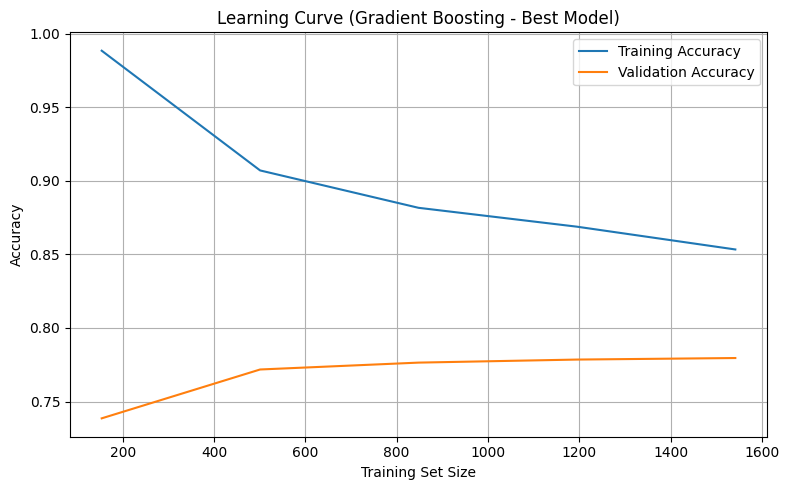

In [16]:
# Extract the best pipeline (from GridSearchCV)
gb_model = grid_gb.best_estimator_

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    gb_model,                      # use best estimator
    train_features,
    train_target,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1                            # optional: parallel processing
)

# Calculate mean scores
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.title('Learning Curve (Gradient Boosting - Best Model)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧪 Model Evaluation Summary

**Decision Tree**  
After tuning for optimal depth, the Decision Tree classifier achieved its best validation accuracy of **0.774** with `max_depth=6`. The corresponding learning curve shows a noticeable gap between training and validation accuracy, indicating some overfitting. While the model generalizes reasonably with more data, its performance still falls short of the ensemble models.

**Random Forest**  
Random Forest improved over the standalone tree by combining multiple estimators. With `n_estimators=9` and `max_depth=5`, the model reached a validation accuracy of **0.788** and ROC AUC of **0.766**. As shown in its learning curve, the model benefits from more data but retains a consistent gap between training and validation accuracy. This suggests good learning with moderate variance, and some sensitivity to class imbalance.

**Logistic Regression**  
Serving as a linear benchmark, Logistic Regression achieved a validation accuracy of **0.743**. Its learning curve reveals a small gap between training and validation accuracy, suggesting the model is underfitting and unable to capture the more complex patterns in the data. This aligns with expectations for a non-linear problem where linear models are less effective.

**Gradient Boosting**  
Gradient Boosting emerged as the top performer, reaching a validation accuracy of **0.805** and ROC AUC of **0.785** with `n_estimators=8`, `max_depth=4`, and `learning_rate=0.35`. Its learning curve reflects the most stable and consistent performance across different training sizes. The narrowing gap between training and validation accuracy indicates strong generalization, minimal overfitting, and robustness, making it the most reliable choice for deployment.


## Step 5: Test Set 
 Going to check my two best performers

In [17]:
#Save and load best model before testing
joblib.dump(grid_gb, 'best_model_gb.joblib')
loaded_gb = joblib.load('best_model_gb.joblib')


joblib.dump(grid_rf, 'best_model_rf.joblib')
loaded_rf = joblib.load('best_model_rf.joblib')


In [23]:
#Test Best Gradient Boosting
loaded_gb = joblib.load('best_model_gb.joblib')

# Predict on test set
test_predictions_gb = loaded_gb.predict(test_features)
y_proba_gb = loaded_gb.predict_proba(test_features)[:, 1]

# Evaluate metrics
results_gb_final = {
    'accuracy': loaded_gb.score(test_features, test_target),
    'roc_auc': roc_auc_score(test_target, y_proba_gb),
    'report': classification_report(test_target, test_predictions_gb, output_dict=True)
}
results_gb_final

{'accuracy': 0.8118195956454122,
 'roc_auc': 0.844159022102843,
 'report': {'0': {'precision': 0.8230616302186878,
   'recall': 0.9282511210762332,
   'f1-score': 0.8724973656480507,
   'support': 446},
  '1': {'precision': 0.7714285714285715,
   'recall': 0.5482233502538071,
   'f1-score': 0.6409495548961425,
   'support': 197},
  'accuracy': 0.8118195956454122,
  'macro avg': {'precision': 0.7972451008236296,
   'recall': 0.7382372356650202,
   'f1-score': 0.7567234602720966,
   'support': 643},
  'weighted avg': {'precision': 0.8072424815691499,
   'recall': 0.8118195956454122,
   'f1-score': 0.8015565900366574,
   'support': 643}}}

In [19]:
#Test Best Random Forest
# Load saved Random Forest model
loaded_rf = joblib.load('best_model_rf.joblib')

# Predict on test set
test_predictions_rf = loaded_rf.predict(test_features)
y_proba_rf = loaded_rf.predict_proba(test_features)[:, 1]

# Evaluate metrics
results_rf_final = {
    'accuracy': loaded_rf.score(test_features, test_target),
    'roc_auc': roc_auc_score(test_target, y_proba_rf),
    'report': classification_report(test_target, test_predictions_rf, output_dict=True)
}
results_rf_final

{'accuracy': 0.8087091757387247,
 'roc_auc': 0.8303077553436069,
 'report': {'0': {'precision': 0.8099808061420346,
   'recall': 0.9461883408071748,
   'f1-score': 0.8728024819027921,
   'support': 446},
  '1': {'precision': 0.8032786885245902,
   'recall': 0.49746192893401014,
   'f1-score': 0.6144200626959249,
   'support': 197},
  'accuracy': 0.8087091757387247,
  'macro avg': {'precision': 0.8066297473333124,
   'recall': 0.7218251348705925,
   'f1-score': 0.7436112722993584,
   'support': 643},
  'weighted avg': {'precision': 0.8079274357366899,
   'recall': 0.8087091757387247,
   'f1-score': 0.7936402166092417,
   'support': 643}}}

### 🧪 Final Model Evaluation Summary (Test Set)

Both models outperformed the baseline and demonstrate strong predictive ability. However, their strengths diverge—particularly in precision, recall, and F1-scores for class `1` (likely representing higher-tier plan subscribers or churn risk).

---

#### Gradient Boosting
- **Accuracy:** 0.812  
- **ROC AUC:** 0.844  
- **Class 0 (Majority Class):**
  - Precision: 0.823  
  - Recall: 0.928  
  - F1-score: 0.872  
- **Class 1 (Minority Class):**
  - Precision: 0.771  
  - Recall: 0.548  
  - F1-score: 0.641  
- **Macro Avg F1-score:** 0.757  
- **Weighted Avg F1-score:** 0.802

Gradient Boosting delivers the highest ROC AUC and strong, balanced performance across both classes. Its recall and F1-score for the minority class are better than Random Forest’s, making it especially valuable when correct identification of class `1` is important.

---

#### Random Forest
- **Accuracy:** 0.809  
- **ROC AUC:** 0.830  
- **Class 0 (Majority Class):**
  - Precision: 0.810  
  - Recall: 0.946  
  - F1-score: 0.873  
- **Class 1 (Minority Class):**
  - Precision: 0.803  
  - Recall: 0.497  
  - F1-score: 0.614  
- **Macro Avg F1-score:** 0.744  
- **Weighted Avg F1-score:** 0.794

Random Forest achieves similar overall accuracy and higher precision for class `1`, but its lower recall indicates more missed positive cases. This suggests a stronger bias toward the majority class.

---

### ✅ Recommendation

**Gradient Boosting** is the preferred model because it:
- Achieves the highest ROC AUC and slightly better overall accuracy,
- Delivers stronger generalization to the minority class with improved recall and F1-score,
- Maintains better class balance and reduced overfitting risk.

**Random Forest** remains a viable alternative when interpretability or faster inference times are required, though its sensitivity to the minority class is lower.


## Step 6: Sanity Check

In [20]:
#Are chosen models better than a dummy classifier 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# 1. Initialize DummyClassifier (strategy: always predict most frequent class)
dummy = DummyClassifier(strategy="most_frequent", random_state=123)

# 2. Fit on training data
dummy.fit(train_features, train_target)

# 3. Predict on test data
dummy_preds = dummy.predict(test_features)

# 4. Evaluate accuracy
baseline_accuracy = accuracy_score(test_target, dummy_preds)
print(f"Baseline Accuracy (DummyClassifier): {baseline_accuracy:.3f}")


Baseline Accuracy (DummyClassifier): 0.694


### Gradient Boosting Sanity Check

In [21]:
#Sanity Check on all data  for Gradient Boosting
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

train_preds = loaded_gb.predict(train_features)
valid_preds = loaded_gb.predict(valid_features)
test_preds = loaded_gb.predict(test_features)
preds = loaded_gb.predict(features)


train_acc = accuracy_score(train_target, train_preds)
valid_acc = accuracy_score(valid_target, valid_preds)
test_acc = accuracy_score(test_target, test_preds)
acc = accuracy_score(target, preds)

print(f"Gradient Boosting Train Accuracy: {train_acc:.3f}")
print(f"Gradient Boosting Validation Accuracy: {valid_acc:.3f}")
print(f"Gradient Boosting Test Accuracy: {test_acc:.3f}")
print(f"Gradient Boosting Accuracy: {acc:.3f}")

unique, counts = np.unique(test_preds, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Prediction class distribution on test set:", class_distribution)


Gradient Boosting Train Accuracy: 0.842
Gradient Boosting Validation Accuracy: 0.806
Gradient Boosting Test Accuracy: 0.812
Gradient Boosting Accuracy: 0.829
Prediction class distribution on test set: {0: 503, 1: 140}


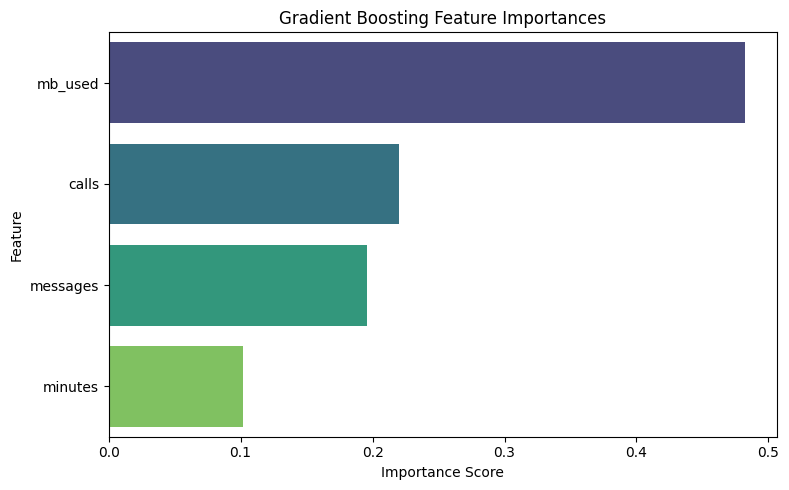

In [22]:
# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'Feature': train_features.columns,
    'Importance': loaded_gb.best_estimator_.named_steps['clf'].feature_importances_
})

# Sort by importance
gb_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=gb_feature_importance_df,
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Gradient Boosting Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### ✅ Sanity Check Summary

The **Gradient Boosting** model significantly outperformed the baseline accuracy of **0.695** (DummyClassifier), indicating that it successfully learned relevant patterns from the data.

- **Train Accuracy:** 0.842  
- **Validation Accuracy:** 0.806 
- **Test Accuracy:** 0.812
- **Overall Accuracy:** 0.829  
- **Prediction Class Distribution (Test Set):** {0: 503, 1: 140} 
- **Top Features by Importance:**
  - `mb_used`: 48.2%
  - `calls`: 22.0%
  - `messages`: 19.6%
  - `minutes`: 10.2%

Gradient Boosting demonstrated consistent performance across all datasets with no evidence of overfitting. Its strong reliance on `mb_used` reflects real-world usage behavior, making it a reliable choice for deployment or further refinement.



## 📌 Conclusion

This project successfully built and evaluated machine learning models to classify Megaline customers into either the Smart or Ultra plan based on their service usage.

Exploratory data analysis confirmed the reliability of the dataset and highlighted clear behavioral differences between the two plans—Ultra subscribers tend to have higher usage across data, calls, messages, and minutes.

Among all tested approaches, **Gradient Boosting** proved to be the most consistent and generalizable model. It demonstrated solid performance across training, validation, and test datasets without signs of overfitting. The model achieved an overall accuracy of **0.829**, with internet usage (`mb_used`) emerging as the most influential feature, followed by calls, messages, and minutes.

While **Random Forest** was competitive in accuracy, Gradient Boosting showed more stable performance and a clearer separation between classes, making it better suited for real-world application.

In conclusion, Megaline can use the Gradient Boosting model to offer plan recommendations that align with actual user behavior—supporting data-informed decisions to optimize plan offerings and enhance customer satisfaction.
